In [1]:
import numpy as np
import pandas as pd
import os, gc, datetime
from utils import *
from processts import *

In [2]:
pp = PreProcessing('test_log','D:/Github/knowledge/time-series/data/logs')

In [3]:
df = pd.read_parquet('data/daikin/dmx_sellout_filldate')
df['trans_date'] = pd.to_datetime(df['trans_date'])

In [ ]:
df1=df.copy()
_now = datetime.datetime.now()
df1 = pp.generate_roll_feature(df1, ['item','location_name'], 'qty', [7,14,28,60],[1,2,3,4,5,6,7])
print(datetime.datetime.now()-_now)

df2=df.copy()
_now = datetime.datetime.now()
df2 = pp.generate_roll_feature_v2(df2, ['item','location_name'], 'qty', [7,14,28,60],[1,2,3,4,5,6,7])
print(datetime.datetime.now()-_now)

In [ ]:
df1.compare(df2[df1.columns])

In [ ]:
df1.columns

In [ ]:
df2.columns

# Check cross validation

In [1]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

def time_series_cross_validation(model, X, y, metric_function, greater_is_better=True, n_splits = 5, test_size = None, n_jobs=None):
    # Create a TimeSeriesSplit object
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
    
    # Create a custom scorer using the provided metric_function
    scorer = make_scorer(metric_function, greater_is_better=greater_is_better)
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X, y, cv=tscv, scoring=scorer, n_jobs=n_jobs)
    
    # Ensure scores are always positive
    sign = 1
    if not greater_is_better:sign=-1

    return sign*(cv_scores)


In [26]:
# Sample Data
np.random.seed(42)
X = np.random.rand(100000, 5)  # 100 time points, 5 features
y = np.random.rand(100000)     # 100 target values (time series)

# Initialize a model
model = RandomForestRegressor()

# Perform cross-validation
cv_scores = time_series_cross_validation(model, X, y, metric_function=root_mean_squared_error, greater_is_better=False, n_splits=5, test_size=1000, n_jobs=-1)

print(f'Cross-validated scores (positive): {cv_scores}')
print(f'Mean score: {np.mean(cv_scores)}')

Cross-validated scores (positive): [0.2889229  0.29110658 0.29594305 0.29320576 0.29463357]
Mean score: 0.29276237447237036


In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
# list các mô hình được lựa chọn
models = [LinearRegression(), KNeighborsRegressor(), MLPRegressor(), RandomForestRegressor()]

all_scores = {}
# Đánh giá toàn bộ các mô hình trên tập K-Fold đã chia
for model in models:
    scores = time_series_cross_validation(model, X, y, metric_function=root_mean_squared_error, greater_is_better=False, n_splits=10, test_size=50)
    all_scores[str(model)] = scores

In [24]:
all_scores

{'LinearRegression()': array([0.28380224, 0.30222175, 0.29364813, 0.2875887 , 0.30345719,
        0.31728108, 0.28841599, 0.27213   , 0.28946883, 0.31853722]),
 'KNeighborsRegressor()': array([0.31712862, 0.31825915, 0.32973373, 0.33038414, 0.30032271,
        0.36063035, 0.30425839, 0.30041213, 0.29297499, 0.32528484]),
 'MLPRegressor()': array([0.29464413, 0.29994305, 0.28592136, 0.2864649 , 0.30445961,
        0.3250218 , 0.28598321, 0.27123253, 0.28566054, 0.31542403]),
 'RandomForestRegressor()': array([0.2868112 , 0.3102882 , 0.30751175, 0.30430506, 0.32390779,
        0.34144173, 0.29473331, 0.26743394, 0.28501361, 0.31849862])}

Text(0.5, 1.0, 'Scores Metrics')

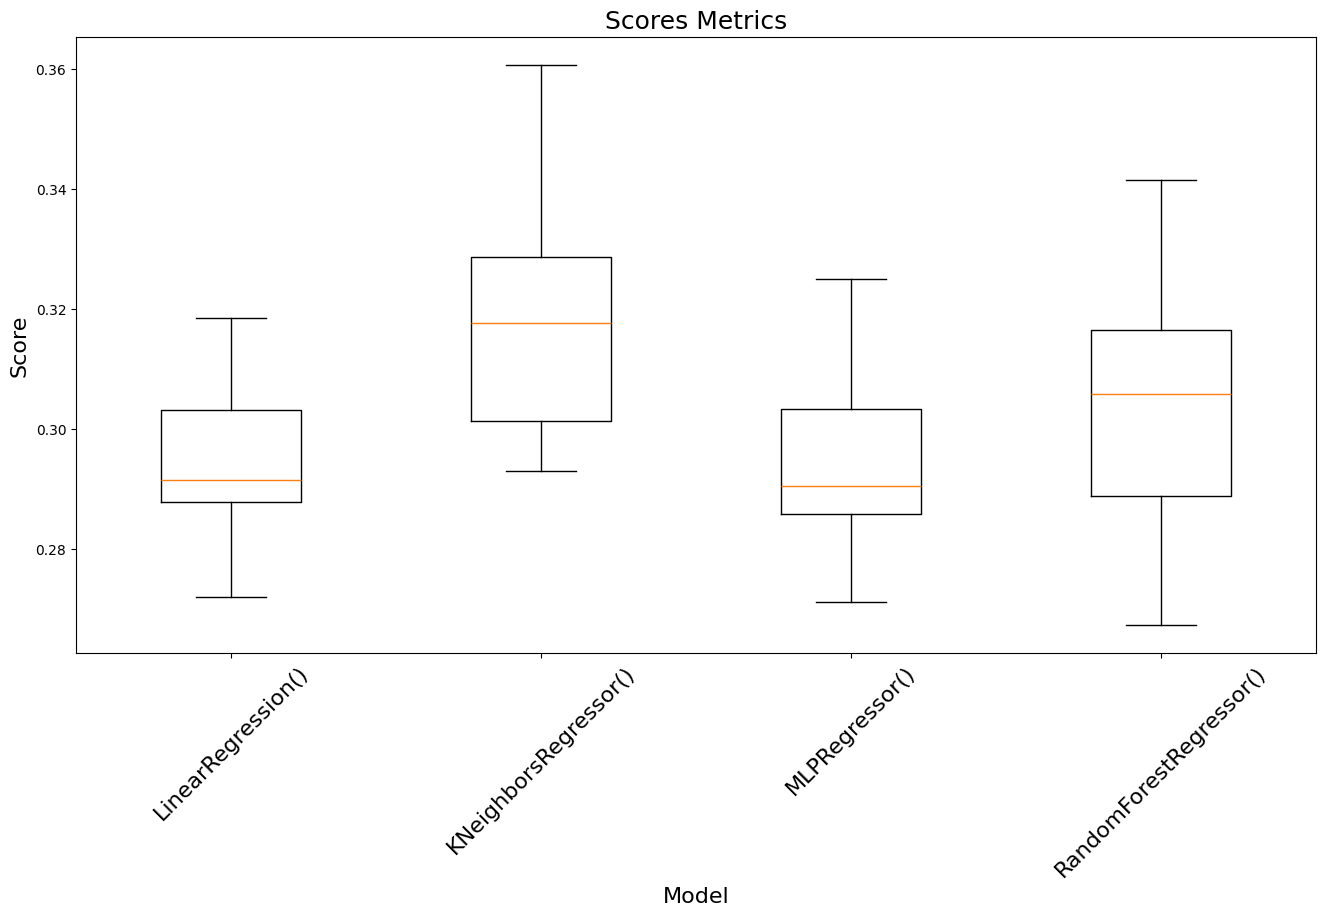

In [25]:
import matplotlib.pyplot as plt

# Draw bboxplot 
plt.figure(figsize=(16, 8))
plt.boxplot(all_scores.values())
plt.xlabel('Model', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.xticks(np.arange(len(all_scores.keys()))+1, all_scores.keys(), rotation=45, fontsize=16)
plt.title("Scores Metrics", fontsize=18)